# EDA y neutralización de payloads XSS del dataset de Kaggle

En este notebook trabajamos con un **dataset de Cross-Site Scripting (XSS) proveniente de Kaggle**, cuyo objetivo es distinguir entre:

- **Texto benigno** (principalmente HTML real de Wikipedia).
- **Payloads maliciosos** diseñados para explotar vulnerabilidades XSS.

El propósito de este notebook es doble:

1. **Exploración y entendimiento del dataset (EDA):**  
   - Cuántos ejemplos hay y cómo están distribuidas las etiquetas.  
   - Cómo se ve el texto real de cada clase.  
   - Qué patrones concretos aparecen en los payloads maliciosos.

2. **Construcción de una función de _neutralización_ de payloads XSS:**  
   - A partir de los datos reales, definimos **familias de patrones XSS**.  
   - Diseñamos funciones que **eliminan o reemplazan de forma segura el JavaScript ejecutable**,  
     pero **mantienen la estructura general del texto HTML**.  
   - Generamos una **versión limpia del dataset** para usarla en un benchmark posterior de mitigación.


In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
plt.rcParams["figure.figsize"] = (8, 4)

# Detect project base directory
cwd = Path.cwd()


def is_project_root(path: Path) -> bool:
    """
    Detect project root by looking for key markers.
    We consider the directory that contains:
    - requirements.txt
    - app/
    - notebooks/
    as the project root.
    """
    markers = ["requirements.txt", "app", "notebooks"]
    return any((path / m).exists() for m in markers)


if is_project_root(cwd):
    # Running from the project root itself
    BASE_DIR = cwd
elif cwd.name in {"notebooks", "src"} and is_project_root(cwd.parent):
    # Running from notebooks/ or src/ → go one level up
    BASE_DIR = cwd.parent
else:
    # Fallback: use current directory (for ad-hoc runs)
    BASE_DIR = cwd

NOTEBOOKS_DIR = BASE_DIR / "notebooks"
NB_DATA_DIR = NOTEBOOKS_DIR / "data"
PROJECT_DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = NB_DATA_DIR / "data_processed"

NB_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROJECT_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH_KAGGLE = NB_DATA_DIR / "XSS_dataset.csv"

print("CWD              :", cwd)
print("BASE_DIR         :", BASE_DIR)
print("NOTEBOOKS_DIR    :", NOTEBOOKS_DIR)
print("NB_DATA_DIR      :", NB_DATA_DIR)
print("OUTPUT_DIR       :", OUTPUT_DIR)
print("DATA_PATH_KAGGLE :", DATA_PATH_KAGGLE)


CWD              : d:\Archivos de Usuario\Documents\xss-cookie\notebooks
BASE_DIR         : d:\Archivos de Usuario\Documents\xss-cookie
NOTEBOOKS_DIR    : d:\Archivos de Usuario\Documents\xss-cookie\notebooks
NB_DATA_DIR      : d:\Archivos de Usuario\Documents\xss-cookie\notebooks\data
OUTPUT_DIR       : d:\Archivos de Usuario\Documents\xss-cookie\notebooks\data\data_processed
DATA_PATH_KAGGLE : d:\Archivos de Usuario\Documents\xss-cookie\notebooks\data\XSS_dataset.csv


## 1. Carga y descripción del dataset

En esta sección cargamos el archivo original de Kaggle y verificamos su estructura básica.

- El archivo esperado es **`XSS_dataset.csv`** ubicado en `notebooks/data/`.  
- Las columnas principales que usaremos son:

  - **`Sentence`**: cadena de texto que puede ser:
    - un fragmento HTML benigno (por ejemplo, texto real de Wikipedia), o  
    - un payload XSS diseñado para ejecutar JavaScript.
  - **`Label`**: etiqueta binaria que indica la clase de cada ejemplo:
    - `0` → benigno  
    - `1` → malicioso

En las siguientes celdas:

1. Cargamos el CSV en un `DataFrame` de pandas.  
2. Mostramos su forma (número de filas y columnas).  
3. Visualizamos algunas filas iniciales para tener una primera idea del contenido.

In [2]:
# Load raw Kaggle dataset
df_raw = pd.read_csv(DATA_PATH_KAGGLE)

print("Shape (rows, columns):", df_raw.shape)
df_raw.head()

Shape (rows, columns): (13686, 3)


,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""image""><img alt=""Socrates.png"" src=""//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/18px-Socrates.png"" decoding=""async"" width=""18"" hei...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steering for the 1995 ""<a href=""/wiki/History_of_autonomous_cars#1990s"" class=""mw-redirect"" title=""History of autonomous cars"">No Hands Across America </a>""...",0
3,3,"\t </span> <span class=""reference-text""><cite class=""citation web""><a rel=""nofollow"" class=""external text"" href=""https://www.mileseducation.com/finance/artificial_intelligence"">""Miles Education | ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_identifier"" title=""Digital object identifier"">doi </a>:<a rel=""nofollow"" class=""external text"" href=""https://doi.org/10.1016%2FS0921-8890%2805%2980025-9"">...",0


Se obtuvo:

- **13686 filas** y **3 columnas** (`Unnamed: 0`, `Sentence`, `Label`).  

Esto significa que contamos con **13 686 ejemplos de texto** etiquetados como benignos o maliciosos.

Observando las primeras filas vemos que:

- Muchos textos benignos son **fragmentos reales de HTML de Wikipedia** (listas, citas, enlaces, etc.).  
- Los textos maliciosos incluyen **etiquetas con atributos extraños** como `onmouseover="alert(1)"`,
  típicos de payloads XSS.

Esta combinación hace que el dataset sea interesante porque mezcla **HTML real** con
**payloads especialmente construidos para atacar navegadores**.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13686 entries, 0 to 13685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13686 non-null  int64 
 1   Sentence    13686 non-null  object
 2   Label       13686 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 320.9+ KB

Label distribution:
 0    6313
1    7373
Name: Label, dtype: int64


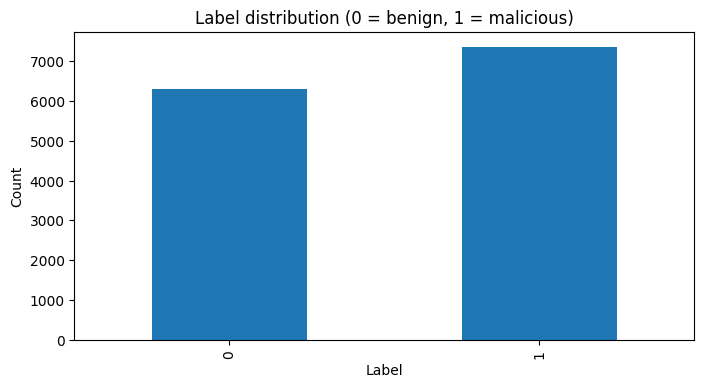

In [3]:
# Inspect basic schema and null values
df_raw.info()

# Label distribution
label_counts = df_raw["Label"].value_counts().sort_index()
print("\nLabel distribution:\n", label_counts)

# Simple bar plot of labels
label_counts.plot(kind="bar")
plt.title("Label distribution (0 = benign, 1 = malicious)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Estructura de columnas y balance de clases

De `info()` obtenemos que:

- Hay **3 columnas**:
  - `Unnamed: 0`: un índice numérico heredado del proceso de generación del CSV.  
  - `Sentence`: el texto (HTML o payload XSS).  
  - `Label`: la clase, codificada como entero (`0` o `1`).  
- No hay valores nulos (`Non-Null Count` = número total de filas).

Además, se obtuvo la siguiente distribución de etiquetas:

- `Label = 0` (benignos): **6313** ejemplos  
- `Label = 1` (maliciosos): **7373** ejemplos  

Esto significa que el dataset es **ligeramente desbalanceado**, con **más ejemplos maliciosos que benignos**,
pero sin una desproporción extrema.

Este balance es adecuado para analizar patrones diferenciales entre clases y entrenar modelos de detección sin necesidad de aplicar, al menos inicialmente, técnicas fuertes de re-muestreo.

## 2. Limpieza preliminar del dataset

Antes de analizar patrones de XSS, realizamos una **limpieza mínima** para:

1. Eliminar columnas que no aportan información semántica.  
2. Normalizar el formato del texto (espacios, tabs, saltos de línea).  
3. Detectar posibles textos vacíos.

Es importante notar que en esta etapa **no alteramos el contenido semántico** de los payloads ni del HTML,
solo preparamos los datos para el análisis exploratorio.

In [4]:
# 1. Drop duplicate index column
df = df_raw.drop(columns=["Unnamed: 0"])

# 2. Ensure Sentence is string
df["Sentence"] = df["Sentence"].astype(str)

# 3. Normalize whitespace (spaces, tabs, newlines)
df["Sentence"] = df["Sentence"].str.replace(r"\s+", " ", regex=True).str.strip()

# 4. Count empty texts after normalization
empty_count = (df["Sentence"] == "").sum()

print("Empty texts after normalization:", empty_count)
df.head()

Empty texts after normalization: 116


,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""image""><img alt=""Socrates.png"" src=""//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/18px-Socrates.png"" decoding=""async"" width=""18"" hei...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"</span> <span class=""reference-text"">Steering for the 1995 ""<a href=""/wiki/History_of_autonomous_cars#1990s"" class=""mw-redirect"" title=""History of autonomous cars"">No Hands Across America </a>"" re...",0
3,"</span> <span class=""reference-text""><cite class=""citation web""><a rel=""nofollow"" class=""external text"" href=""https://www.mileseducation.com/finance/artificial_intelligence"">""Miles Education | Fut...",0
4,"</span>. <a href=""/wiki/Digital_object_identifier"" title=""Digital object identifier"">doi </a>:<a rel=""nofollow"" class=""external text"" href=""https://doi.org/10.1016%2FS0921-8890%2805%2980025-9"">10....",0


Después de eliminar la columna de índice duplicado y normalizar espacios se identificaron **116 textos vacíos** (`Sentence` igual a cadena vacía). Estos casos suelen corresponder a fragmentos de HTML muy cortos o a residuos de extracción. Podemos mantenerlos en el dataset porque **no afectan directamente** a la construcción de patrones XSS, pero es importante conocer su existencia.

En el resto de filas, el contenido se mantiene, pero ahora los textos son más uniformes y es menos probable que patrones de XSS queden escondidos detrás de tabs `\t` o espacios duplicados.

Esta limpieza nos permite realizar análisis estadísticos y búsquedas de patrones de forma más robusta.

        count        mean         std  min   25%   50%    75%     max
Label                                                                
0      6313.0  161.152542  294.416582  0.0  18.0  89.0  122.0  5909.0
1      7373.0   62.382070   32.616573  5.0  42.0  52.0   65.0   425.0


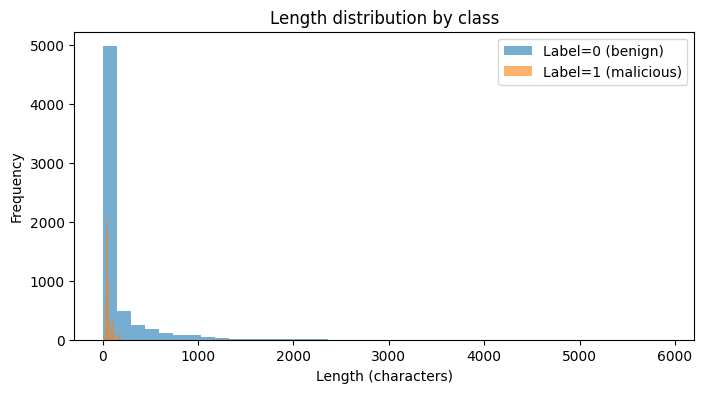

In [5]:
# Compute character length for each sentence
df["len_chars"] = df["Sentence"].str.len()

# Summary statistics of length by label
length_stats = df.groupby("Label")["len_chars"].describe()
print(length_stats)

# Histogram by class
plt.hist(df[df["Label"] == 0]["len_chars"], bins=40, alpha=0.6, label="Label=0 (benign)")
plt.hist(df[df["Label"] == 1]["len_chars"], bins=40, alpha=0.6, label="Label=1 (malicious)")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.title("Length distribution by class")
plt.legend()
plt.show()

## 3. Análisis de longitudes de los textos

El dataset mezcla dos tipos de contenidos muy distintos:

- **HTML benigno**: fragmentos de páginas reales de Wikipedia, a menudo bastante largos.  
- **Payloads XSS**: cadenas cortas, diseñadas para disparar eventos o ejecutar JavaScript con la mínima longitud posible.

En la ejecución original se observaron estadísticas de longitud (número de caracteres) como las siguientes:

- Para `Label = 0` (benignos):
  - Media ≈ **161 caracteres**, con una desviación estándar alta.  
  - Valores mínimos cercanos a 0 y máximos que superan los **5000 caracteres**
    (páginas completas o grandes fragmentos).

- Para `Label = 1` (maliciosos):
  - Media ≈ **62 caracteres**, con menor variabilidad.  
  - Longitudes típicas entre 40 y 70 caracteres, con máximos alrededor de 400.

El histograma confirma esta intuición:

- Los ejemplos benignos tienden a ser **mucho más largos**, con una cola larga hacia la derecha.  
- Los ejemplos maliciosos se concentran en longitudes cortas y medianas.

Este contraste en la longitud es importante porque:

- Sugiere que **la longitud por sí sola** ya aporta información útil
  para distinguir entre HTML real y payloads XSS.  
- Nos ayuda a interpretar los resultados posteriores: muchos payloads maliciosos serán
  cadenas cortas con estructuras muy específicas.

In [6]:
def show_samples_by_label(label: int, n: int = 5) -> None:
    subset = df[df["Label"] == label].sample(n, random_state=42)
    print(f"\n=== Examples Label={label} ===")
    for _, row in subset.iterrows():
        print("\n---")
        print(row["Sentence"])


show_samples_by_label(0, 3)  # benign
show_samples_by_label(1, 3)  # malicious


=== Examples Label=0 ===

---
</span></a>.</dd>

---
<li><a href="/wiki/Visualization_(graphics)" title="Visualization (graphics)">Visualization </a> </li>

---
</span> <span class="reference-text">The most dramatic case of sub-symbolic AI being pushed into the background was the devastating critique of <a href="/wiki/Perceptron" title="Perceptron">perceptrons </a> by <a href="/wiki/Marvin_Minsky" title="Marvin Minsky">Marvin Minsky </a> and <a href="/wiki/Seymour_Papert" title="Seymour Papert">Seymour Papert </a> in 1969. See <a href="/wiki/History_of_AI" class="mw-redirect" title="History of AI">History of AI </a>, <a href="/wiki/AI_winter" title="AI winter">AI winter </a>, or <a href="/wiki/Frank_Rosenblatt" title="Frank Rosenblatt">Frank Rosenblatt </a>.

=== Examples Label=1 ===

---
<time onpointermove=alert(1)>XSS</time>

---
<col onbeforepaste="alert(1)" contenteditable>test</col>

---
<meta id=x tabindex=1 onbeforedeactivate=alert(1)></meta><input autofocus>


Al inspeccionar manualmente algunas muestras:

Los ejemplos con `Label = 0` suelen ser:
  - Listas (`<li>...</li>`), tablas `<table>`, `<span>` con referencias, etc.  
  - Fragmentos largos de texto descriptivo, citas, enlaces externos, metadatos.

Los ejemplos con `Label = 1` muestran patrones típicos de XSS, por ejemplo:
  - Atributos como `onmouseover`, `onfocus`, `onpointermove`, etc.  
  - Etiquetas con atributos inesperados que disparan `alert(1)` u otras llamadas JavaScript.  
  - Tags poco comunes o usados de forma sospechosa
    (`<time onpointermove=alert(1)>XSS</time>`, `<meta ... onbeforedeactivate=alert(1)>`, etc.).

Esta inspección cualitativa justifica que:

1. **Los atributos de evento (`onXYZ`) son un objetivo central de nuestra neutralización.**  
2. Necesitamos clasificar no solo por la etiqueta HTML, sino también por los **patrones internos**
   del texto (atributos, esquemas, símbolos).

## 4. Extracción automática de patrones recurrentes en payloads XSS

En lugar de asumir a priori qué patrones de XSS son importantes, aquí dejamos que **el propio dataset nos diga**:

1. **Qué atributos `on...` aparecen con más frecuencia.**  
2. **Qué etiquetas HTML (`<svg>`, `<iframe>`, `<img>`, etc.) dominan en los payloads maliciosos.**  
3. **Qué esquemas de URI aparecen (`javascript:`, `data:`, `ascript:`...).**  
4. **Qué combinaciones de símbolos especiales (`><`, `">`, etc.) son frecuentes.**

Este análisis nos permitirá construir una **lista de patrones basada exclusivamente en evidencia empírica**
del dataset de Kaggle, evitando basarnos solo en listas de payloads predefinidas.

In [7]:
# Convenience series with only malicious sentences
malicious = df[df["Label"] == 1]["Sentence"]

# 1) Event handler attributes onXYZ=
on_attrs = malicious.str.extractall(r"\b(on\w+)\s*=").value_counts()
print("Top event handler attributes:\n", on_attrs.head(20), "\n")

# 2) HTML tags
tags = malicious.str.extractall(r"<\s*(\w+)").value_counts()
print("Top tags in malicious payloads:\n", tags.head(30), "\n")

# 3) URI-like schemes (xxx:)
schemes = malicious.str.extractall(r"([a-zA-Z]+)\s*:").value_counts()
print("Top schemes:\n", schemes.head(20), "\n")

# 4) Polyglot-like symbol patterns
poly = malicious.str.extractall(r"([><`'\"]{1,3})").value_counts()
print("Top polyglot-like symbol sequences:\n", poly.head(20))

Top event handler attributes:
 onpointerleave          153
onpointermove           153
onpointerenter          153
onpointerdown           153
onpointerout            153
onpointerover           153
onpointerup             153
onload                  152
onmouseover             151
onfocusin               146
onfocus                 146
onfocusout              143
onactivate              143
ontransitionrun         143
onanimationend          143
onanimationiteration    143
onbeforeactivate        143
onblur                  142
ontransitioncancel      142
onanimationcancel       142
dtype: int64 

Top tags in malicious payloads:
 style       1048
input        636
div          333
svg          200
source        87
body          69
img           66
video         65
audio         64
a             61
image         59
script        57
iframe        57
form          56
picture       55
textarea      54
marquee       53
frameset      53
isindex       52
applet        52
object        52
deta

### Patrones dominantes encontrados en los payloads maliciosos

A partir del conteo automático se observan varios patrones clave:

1. **Atributos de evento (`on*`)**  
   - Atributos como `onpointermove`, `onpointerenter`, `onload`, `onmouseover`,
     `onfocus`, `onanimationend`, etc., aparecen **cientos de veces**.  
   - Esto indica que una gran parte de los payloads del dataset explotan la capacidad
     de los navegadores de ejecutar JavaScript a partir de **eventos de interacción** (hover, focus, load, etc.).

2. **Etiquetas HTML más frecuentes**  
   - Entre las etiquetas que más se repiten en los ejemplos maliciosos están:  
     `style`, `input`, `div`, `svg`, `body`, `img`, `video`, `audio`, `script`, `iframe`,
     `form`, `textarea`, `object`, `applet`, `embed`, etc.  
   - Muchas de estas etiquetas son conocidas por ser **vectores clásicos de XSS**,
     ya sea porque permiten inyectar código (`<script>`) o porque pueden cargar recursos externos
     (`<img>`, `<iframe>`, `<object>`, etc.).

3. **Esquemas de URI**  
   - Aparecen esquemas como `javascript:`, `data:`, e incluso variantes ofuscadas como `ascript:`.  
   - El esquema `javascript:` es especialmente crítico, ya que permite ejecutar código JavaScript
     directamente desde atributos como `href` o `src`.

4. **Patrones de símbolos tipo polyglot**  
   - Secuencias como `<`, `>`, `"><`, `">`, `""`, `''`, etc., aparecen muy frecuentemente.  
   - Estos patrones suelen formar parte de **técnicas de evasión** o de **inyección en contexto HTML/atributos**,
     por ejemplo, cerrando un atributo y abriendo otro tag para inyectar un script.

En resumen, este análisis confirma que el dataset contiene una **gran variedad de vectores XSS realistas**,
y nos da una base sólida para definir un conjunto de patrones y familias de ataque.

## 5. Construcción de una lista final de patrones XSS basada en datos

A partir del análisis anterior, definimos una lista de **patrones regulares (`regex`) agrupados por tipo**,
que usaremos como base para:

- Marcar la presencia o ausencia de un patrón en cada fila.  
- Clasificar cada payload dentro de una **familia dominante**.  
- Diseñar estrategias específicas de neutralización por familia.

La lista incluye:

1. **Atributos de eventos** (`on_event`):  
   - Cubre cualquier atributo que empiece con `on` seguido de letras o números.  
   - Ejemplo: `onload=`, `onmouseover=`, `onpointerenter=`, etc.

2. **Etiquetas activas peligrosas** (`svg`, `iframe`, `video`, `audio`, `embed`, `object`, `applet`).  

3. **Etiquetas relacionadas con imágenes** (`img`, `image`, `picture`, `source`).  

4. **Etiquetas de formulario** (`input`, `form`, `textarea`, `button`).  

5. **Etiquetas de estilo/meta** (`style`, `link`, `meta`).  

6. **Esquemas de URI sospechosos** (`javascript:`, `data:`, `ascript:`, `vbscript:`).  

7. **Patrones de símbolos tipo polyglot**, que se comportan más como **ruido compartido**
   entre benignos y maliciosos que como un indicador exclusivo de ataque.

In [8]:
patterns_final = {
    # Event handler family — detects all onXYZ handlers
    "on_event": r"(on[a-zA-Z0-9]+)\s*=",

    # Active dangerous tags
    "tag_svg": r"<\s*svg",
    "tag_iframe": r"<\s*iframe",
    "tag_script": r"<\s*script",
    "tag_video": r"<\s*video",
    "tag_audio": r"<\s*audio",
    "tag_embed": r"<\s*embed",
    "tag_object": r"<\s*object",
    "tag_applet": r"<\s*applet",

    # Image-related tags
    "tag_img": r"<\s*img",
    "tag_image": r"<\s*image",
    "tag_picture": r"<\s*picture",
    "tag_source": r"<\s*source",

    # Form and UI elements
    "tag_input": r"<\s*input",
    "tag_form": r"<\s*form",
    "tag_textarea": r"<\s*textarea",
    "tag_button": r"<\s*button",

    # Meta/CSS/redirect-related tags
    "tag_style": r"<\s*style",
    "tag_link": r"<\s*link",
    "tag_meta": r"<\s*meta",

    # Suspicious URI schemes
    "scheme_javascript": r"javascript\s*:",
    "scheme_data": r"data\s*:",
    "scheme_ascript": r"ascript\s*:",
    "scheme_vbscript": r"vbscript\s*:",  # completeness

    # Polyglot-like patterns
    "poly_gt_lt": r"><",
    "poly_quote_gt": r"\">",
    "poly_quote_lt": r"\"<",
    "poly_double_quote": r"\"\"",
    "poly_single_quote": r"''",
}

## 6. Aplicación de patrones al dataset completo

En esta sección:

1. Aplicamos cada `regex` a la columna `Sentence`.  
2. Creamos una columna booleana por patrón (verdadero si aparece en la fila, falso en caso contrario).  
3. Calculamos:
   - La **frecuencia global** de cada patrón.  
   - La **frecuencia separada por clase** (benigno vs malicioso).

Esto nos permitirá:

- Ver qué patrones son realmente característicos de los payloads maliciosos.  
- Detectar patrones que aparecen en ambos tipos de texto (ruido compartido).  
- Ajustar nuestra estrategia de neutralización para concentrarnos en los puntos críticos.

In [9]:
df_patterns = df.copy()

# Create one boolean column per pattern
for name, regex in patterns_final.items():
    df_patterns[name] = df_patterns["Sentence"].str.contains(
        regex, flags=re.IGNORECASE, regex=True
    )

# 1. Global frequency of each pattern
freq_global = df_patterns[list(patterns_final.keys())].mean().sort_values(
    ascending=False
)
print("=== GLOBAL pattern frequency (proportion of rows) ===")
print(freq_global)

# 2. Frequency by class
freq_by_label = (
    df_patterns.groupby("Label")[list(patterns_final.keys())]
    .mean()
    .T  # patterns as rows
    .sort_values(by=1, ascending=False)  # sort by malicious frequency
)

print("\n=== Pattern frequency by class (0 = benign, 1 = malicious) ===")
freq_by_label

C:\Users\HP\AppData\Local\Temp\ipykernel_23864\4247333286.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_patterns[name] = df_patterns["Sentence"].str.contains(


=== GLOBAL pattern frequency (proportion of rows) ===
on_event             0.524916
poly_quote_gt        0.505334
poly_gt_lt           0.468654
tag_style            0.076794
tag_input            0.048736
tag_link             0.028789
scheme_data          0.023089
tag_svg              0.014613
tag_img              0.011106
tag_script           0.007891
tag_source           0.006357
tag_image            0.005334
tag_video            0.004822
tag_meta             0.004822
tag_audio            0.004676
tag_form             0.004311
poly_single_quote    0.004311
tag_iframe           0.004165
tag_picture          0.004019
poly_double_quote    0.004019
tag_textarea         0.003946
scheme_ascript       0.003946
tag_object           0.003873
tag_applet           0.003800
tag_embed            0.003726
tag_button           0.003653
scheme_javascript    0.003653
poly_quote_lt        0.003434
scheme_vbscript      0.000073
dtype: float64

=== Pattern frequency by class (0 = benign, 1 = malicious) =

Label,0,1
on_event,0.001426,0.973145
poly_quote_gt,0.651671,0.380035
poly_gt_lt,0.597497,0.358334
tag_style,0.000158,0.142412
tag_input,0.002059,0.088702
tag_svg,0.000000,0.027126
tag_img,0.008079,0.013699
tag_source,0.000000,0.011800
tag_script,0.004435,0.010850
tag_image,0.000000,0.009901


A partir de los resultados originales se observa que:

A nivel **global**, los patrones más frecuentes son:
  - `on_event` (atributos de evento), presente en más de la mitad de las filas.  
  - Patrones `poly_quote_gt` (`">`) y `poly_gt_lt` (`><`), muy frecuentes por ser parte de HTML real y payloads.

Al separar por clase (`Label = 0` vs `Label = 1`), las diferencias se hacen claras:
  - `on_event` casi **no aparece** en ejemplos benignos (proporción muy cercana a 0),
    pero está presente en **casi todos los maliciosos** (proporción ≈ 0.97).  
    → Es un **indicador fuertísimo de XSS** en este dataset.  
  - Tags como `style`, `input`, `svg`, `video`, `audio`, `iframe`, etc.,
    tienen proporciones mucho más altas en la clase maliciosa que en la benigna.  
  - `scheme_javascript` y `scheme_ascript` aparecen exclusivamente o casi exclusivamente en la clase maliciosa.  
  - Algunos patrones como `scheme_data`, `poly_quote_gt`, `poly_gt_lt` y otros aparecen en **ambas clases**,
    lo que indica que no pueden interpretarse como maliciosos por sí solos.

Este análisis cuantitativo respalda la idea de que **no todos los patrones deben tratarse igual**:

- Algunos son **claros vectores de ejecución de código** y deben ser neutralizados.  
- Otros son **rasgos estructurales del HTML** (como ciertos símbolos o estilos) que es mejor conservar,
  ya que forman parte del comportamiento legítimo.

## 7. Clasificación de payloads por familias de patrones

Para poder diseñar una neutralización más inteligente, agrupamos los patrones en
**familias de payloads XSS**.  
La idea es asignar a cada fila una **familia dominante**, según los patrones que aparecen en su texto.

Definimos las siguientes familias:

1. **`event_handler`**: Payloads que dependen de atributos `onXYZ=` para ejecutar código.

2. **`active_tag`**: Payloads basados en etiquetas activas peligrosas:
     `svg`, `iframe`, `video`, `audio`, `embed`, `object`, `applet`.

3. **`image_tag`**: Payloads en etiquetas de imagen (`img`, `image`, `picture`, `source`).

4. **`form_tag`**: Payloads embebidos en elementos de formulario (`input`, `form`, `textarea`, `button`).

5. **`meta_tag`**: Etiquetas relacionadas con estilos y metadatos (`style`, `link`, `meta`).

6. **`scheme`**: Textos que contienen esquemas sospechosos como `javascript:` o `ascript:`.

7. **`neutral_polyglot`**: Patrones de símbolos como `><`, `">`, `""`, etc., que aparecen tanto en benignos como maliciosos (ruido compartido).

8. **`other`**: Cualquier caso que no encaja en las categorías anteriores.

A continuación implementamos una función que asigna una familia a cada fila,
siguiendo un orden de prioridad (primero `event_handler`, luego `active_tag`, etc.).

In [10]:
def classify_family(row) -> str:
    # 1. Event handlers
    if row["on_event"]:
        return "event_handler"

    # 2. Active dangerous tags
    if any(
        row[t]
        for t in [
            "tag_svg",
            "tag_iframe",
            "tag_video",
            "tag_audio",
            "tag_embed",
            "tag_object",
            "tag_applet",
        ]
    ):
        return "active_tag"

    # 3. Image-based vectors
    if any(row[t] for t in ["tag_img", "tag_image", "tag_picture", "tag_source"]):
        return "image_tag"

    # 4. Form elements
    if any(row[t] for t in ["tag_input", "tag_form", "tag_textarea", "tag_button"]):
        return "form_tag"

    # 5. Meta/CSS/redirect
    if any(row[t] for t in ["tag_style", "tag_link", "tag_meta"]):
        return "meta_tag"

    # 6. URI schemes
    if any(row[t] for t in ["scheme_javascript", "scheme_ascript", "scheme_vbscript"]):
        return "scheme"

    # 7. Polyglot-like patterns (noise)
    if any(
        row[t]
        for t in [
            "poly_gt_lt",
            "poly_quote_gt",
            "poly_quote_lt",
            "poly_double_quote",
            "poly_single_quote",
        ]
    ):
        return "neutral_polyglot"

    return "other"


df_patterns["family"] = df_patterns.apply(classify_family, axis=1)

family_counts = df_patterns["family"].value_counts()
print(family_counts)

event_handler       7184
neutral_polyglot    4225
other               1797
meta_tag             355
image_tag             74
scheme                22
form_tag              20
active_tag             9
Name: family, dtype: int64


### Distribución de familias de payloads

En la ejecución original la distribución de familias fue aproximadamente:

- `event_handler`: **7184** filas  
- `neutral_polyglot`: **4225** filas  
- `other`: **1797** filas  
- `meta_tag`: 355 filas  
- `image_tag`: 74 filas  
- `scheme`: 22 filas  
- `form_tag`: 20 filas  
- `active_tag`: 9 filas  

Esta distribución revela varios puntos importantes:

1. La familia **`event_handler`** es, con diferencia, la más dominante.  
   Esto coincide con el hecho de que muchos payloads del dataset explotan eventos
     como `onload`, `onmouseover`, `onpointerenter`, etc.
2. La familia **`neutral_polyglot`** agrupa sobre todo HTML benigno y ruido compartido.  
   No necesariamente son ataques, sino combinaciones de símbolos típicas del HTML real.
3. Las familias **`active_tag`**, **`image_tag`**, **`scheme`** y **`form_tag`**
   son menos frecuentes, pero **muy relevantes desde el punto de vista de seguridad**,
   porque representan vectores XSS clásicos.

Esta clasificación por familias será la base para aplicar **estrategias de neutralización adaptadas**
a cada tipo de payload.

In [11]:
def show_samples_by_family(family: str, n: int = 5) -> None:
    subset = df_patterns[df_patterns["family"] == family]["Sentence"]
    subset = subset.sample(n=min(n, len(subset)), random_state=42)
    print(f"\n=== Family: {family} (n={len(subset)}) ===")
    for s in subset:
        print("\n---")
        print(s)


for fam in df_patterns["family"].unique():
    show_samples_by_family(fam, n=5)


=== Family: image_tag (n=5) ===

---
<div class="thumbinner" style="width:222px;"><a href="/wiki/File:%C3%84%C3%A4retuvastuse_n%C3%A4ide.png" class="image"><img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/20/%C3%84%C3%A4retuvastuse_n%C3%A4ide.png/220px-%C3%84%C3%A4retuvastuse_n%C3%A4ide.png" decoding="async" width="220" height="73" class="thumbimage" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/20/%C3%84%C3%A4retuvastuse_n%C3%A4ide.png/330px-%C3%84%C3%A4retuvastuse_n%C3%A4ide.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/20/%C3%84%C3%A4retuvastuse_n%C3%A4ide.png/440px-%C3%84%C3%A4retuvastuse_n%C3%A4ide.png 2x" data-file-width="1415" data-file-height="471" /> </a> <div class="thumbcaption">

---
<IMG SRC="livescript:[code]">

---
<IMG """><SCRIPT>alert("")</SCRIPT>"\>

---
<li><a href="/wiki/File:Socrates.png" class="image"><img alt="Socrates.png" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Socrates.png/18px-Socrates.png" decoding=

Al mirar ejemplos concretos de cada familia, confirmamos que la clasificación tiene sentido:

- **`image_tag`**: mezcla de HTML benigno con `<img>` legítimos y ejemplos claramente maliciosos
  como `SRC="javascript:alert('')"` o variantes ofuscadas.  
- **`event_handler`**: tags sencillos (`<u>`, `<h1>`, `<span>`, etc.) con atributos como `onclick`,
  `onkeyup`, `ondblclick`, `onpointerenter`, etc., que ejecutan `alert(1)`.  
- **`meta_tag`**: principalmente etiquetas como `<link ...>` y `<style>...`, muchas de ellas benignas,
  pero con potencial de abuso si se modifican.  
- **`scheme`**: cadenas cuyo núcleo es `javascript:alert('')`, `javascript:document.location=`, etc.  
- **`active_tag`**: casos raros pero potentes, como:
  - `<svg><script xlink:href=data&colon;,window.open('https://www.google.com/')></script`  
  - `<iframe src=javascript&colon;alert(...)>`  
  - `<object data="javascript:alert()">`.

Esta inspección manual nos ayuda a **no tratar todo como “malicioso por igual”**, sino diferenciar
qué partes del texto realmente contienen JavaScript ejecutable y cuáles son solo contexto HTML.

## 8. Diseño de la función de neutralización basada en familias

El objetivo de la neutralización es construir una versión **segura** del dataset que cumpla:

1. **Eliminar la capacidad de ejecutar JavaScript**, neutralizando los vectores de ataque.  
2. **Conservar la estructura general del HTML y el contexto alrededor del payload.**  
3. **Dejar trazas claras** (tokens) de que hubo un payload, para poder evaluarlo en un benchmark de mitigación.

### Principios de diseño

- Solo neutralizamos las familias que realmente contienen **código ejecutable**:
  - `event_handler`  
  - `scheme`  
  - `active_tag`  
  - `image_tag`  

- No tocamos (o tocamos mínimamente) las familias que se consideran **ruido o HTML benigno**:
  - `neutral_polyglot`, `meta_tag`, `form_tag`, `other`.

### Tokens neutros

Usamos tokens legibles que reemplazan el contenido dañino:

- `EVENT_HANDLER_PAYLOAD` para atributos `onXYZ=...`  
- `JAVASCRIPT_SCHEME_PAYLOAD` para esquemas `javascript:` y variantes  
- `SCRIPT_PAYLOAD` y `JS_PAYLOAD` para contenido de `<script>` si fuese necesario

En las siguientes celdas implementamos y refinamos estas funciones.

In [12]:
# Neutralization tokens
TOKEN_EVENT = "EVENT_HANDLER_PAYLOAD"
TOKEN_JS_SCHEME = "JAVASCRIPT_SCHEME_PAYLOAD"
TOKEN_SCRIPT = "SCRIPT_PAYLOAD"
TOKEN_GENERAL_JS = "JS_PAYLOAD"


def neutralize_event_handler(text: str) -> str:
    """
    Neutralize attributes of the form onXYZ=... (with or without quotes).
    Replace their value with a constant token EVENT_HANDLER_PAYLOAD.
    Example:
        <a onclick=alert(1)>  -> <a onclick="EVENT_HANDLER_PAYLOAD">
        <div onload="alert(1)"> -> <div onload="EVENT_HANDLER_PAYLOAD">
    """
    if not isinstance(text, str):
        return text

    pattern = re.compile(
        r'(on[a-zA-Z0-9]+)\s*=\s*(".*?"|\'.*?\'|[^\s>]+)',
        flags=re.IGNORECASE,
    )

    def replace(match: re.Match) -> str:
        attr = match.group(1)
        return f'{attr}="{TOKEN_EVENT}"'

    return pattern.sub(replace, text)


def neutralize_script_tags(text: str) -> str:
    """
    Replace the inner content of <script>...</script> by a neutral token,
    preserving the tag structure.
    """
    if not isinstance(text, str):
        return text

    return re.sub(
        r"<\s*script[^>]*>.*?<\s*/script\s*>",
        f"<script>{TOKEN_SCRIPT}</script>",
        text,
        flags=re.IGNORECASE | re.DOTALL,
    )


def neutralize_js_scheme(text: str) -> str:
    """
    Neutralize URI schemes like javascript:...,
    javascript&colon;..., and ascript:...,
    replacing them with a neutral token while preserving
    the surrounding HTML structure.
    """
    if not isinstance(text, str):
        return text

    # 1) javascript:... and javascript&colon:...
    pattern_js = re.compile(
        r"javascript\s*(?:\:|&colon;)[^\s>'\"]*",
        flags=re.IGNORECASE,
    )
    text2 = pattern_js.sub(f"javascript:{TOKEN_JS_SCHEME}", text)

    # 2) ascript:... (rare obfuscated variant)
    pattern_ascript = re.compile(
        r"\bascript\s*:[^\s>'\"]*",
        flags=re.IGNORECASE,
    )
    text2 = pattern_ascript.sub(f"ascript:{TOKEN_JS_SCHEME}", text2)

    return text2


def neutralize_active_tag(text: str) -> str:
    """
    Neutralize JavaScript schemes and <script> content inside active tags
    such as <svg>, <iframe>, <object>, <embed>, etc.
    """
    text = neutralize_js_scheme(text)
    text = neutralize_script_tags(text)
    return text


def neutralize_image_tag(text: str) -> str:
    """
    Neutralize JavaScript schemes used in image-related attributes,
    such as src="javascript:...".
    """
    text = neutralize_js_scheme(text)
    return text


def clean_residues(text: str) -> str:
    """
    Clean typical leftover residues from broken payloads after neutralization,
    especially for the scheme family, where the original dataset contains
    malformed JavaScript fragments.
    """
    if not isinstance(text, str):
        return text

    patterns_cleanup = [
        r"''\)",  # '')
        r'""\)',  # "")
        r"'\)",   # ')
        r'"\)',   # ")
        r"''\"\)",  # '')")
        r"\"\)\"",  # ")"
    ]

    cleaned = text
    for pat in patterns_cleanup:
        cleaned = re.sub(pat, "", cleaned)

    return cleaned

In [13]:
def neutralize_by_family(text: str, family: str) -> str:
    """
    Apply family-specific neutralization rules.
    Only some families are modified; others are returned unchanged.
    """
    if family == "event_handler":
        # Neutralize event handlers only (no extra residue cleaning)
        return neutralize_event_handler(text)
    if family == "scheme":
        # Neutralize JS schemes and then clean leftovers
        return clean_residues(neutralize_js_scheme(text))
    if family == "active_tag":
        # Neutralize JS inside active tags (no residue cleaning)
        return neutralize_active_tag(text)
    if family == "image_tag":
        # Neutralize JS in image-related tags
        return neutralize_image_tag(text)

    # For benign/noisy families we keep the text as is
    return text


# Quick sanity check on a small malicious sample
df_test = df_patterns[df_patterns["Label"] == 1].sample(10, random_state=42)

for sent, fam in zip(df_test["Sentence"], df_test["family"]):
    print("\n--- ORIGINAL ---")
    print(sent)
    print("FAMILY:", fam)
    print("--- NEUTRALIZED ---")
    print(neutralize_by_family(sent, fam))


--- ORIGINAL ---
<time onpointermove=alert(1)>XSS</time>
FAMILY: event_handler
--- NEUTRALIZED ---
<time onpointermove="EVENT_HANDLER_PAYLOAD">XSS</time>

--- ORIGINAL ---
<col onbeforepaste="alert(1)" contenteditable>test</col>
FAMILY: event_handler
--- NEUTRALIZED ---
<col onbeforepaste="EVENT_HANDLER_PAYLOAD" contenteditable>test</col>

--- ORIGINAL ---
<meta id=x tabindex=1 onbeforedeactivate=alert(1)></meta><input autofocus>
FAMILY: event_handler
--- NEUTRALIZED ---
<meta id=x tabindex=1 onbeforedeactivate="EVENT_HANDLER_PAYLOAD"></meta><input autofocus>

--- ORIGINAL ---
<frameset><frame onload=alert(1)>
FAMILY: event_handler
--- NEUTRALIZED ---
<frameset><frame onload="EVENT_HANDLER_PAYLOAD">

--- ORIGINAL ---
<u id=x tabindex=1 onbeforeactivate=alert(1)></u>
FAMILY: event_handler
--- NEUTRALIZED ---
<u id=x tabindex=1 onbeforeactivate="EVENT_HANDLER_PAYLOAD"></u>

--- ORIGINAL ---
<span onpointerenter=alert(1)>XSS</span>
FAMILY: event_handler
--- NEUTRALIZED ---
<span onpointe

En los ejemplos impresos se puede observar que:

- Para la familia **`event_handler`**, expresiones como:
  - `onpointermove=alert(1)`  
  - `onbeforeactivate=alert(1)`  
  - `ondblclick="alert(1)"`  
  se transforman en:
  - `onpointermove="EVENT_HANDLER_PAYLOAD"`  
  - `onbeforeactivate="EVENT_HANDLER_PAYLOAD"`  
  - `ondblclick="EVENT_HANDLER_PAYLOAD"`  

  Es decir, **se conserva el atributo y la estructura del tag**, pero se reemplaza el código
  ejecutable por un token neutro.

- Para la familia **`scheme`**, casos como:
  - `javascript:alert('')`  
  - cadenas del tipo `SRC="javascript:..."`  
  se convierten en:
  - `javascript:JAVASCRIPT_SCHEME_PAYLOAD`  
  - `SRC="javascript:JAVASCRIPT_SCHEME_PAYLOAD"`  

  Además, se limpian residuos típicos de payloads mal formados.

- Para las familias **`active_tag`** e **`image_tag`**, se neutralizan esquemas como `javascript:`
  dentro de `<iframe>`, `<object>`, `<img>`, etc., sin eliminar toda la etiqueta ni destruir el HTML.

En conjunto, estas transformaciones logran el objetivo de **romper la capacidad de ejecutar JavaScript**,
pero **mantener trazas claras** de por qué ese texto era peligroso.

## 9. Aplicación de la neutralización a todo el dataset

En esta etapa aplicamos la función `neutralize_by_family` a **todas las filas** del dataset,
utilizando la familia asignada a cada una.

Para eso hacemos lo siguiente:

1. Creamos una nueva columna `Sentence_clean` que contiene la versión neutralizada del texto original.  
2. Comparamos `Sentence` vs `Sentence_clean` para marcar si hubo cambios.  
3. Calculamos:
   - Cuántas filas cambiaron a nivel global.  
   - Qué porcentaje de filas cambió dentro de cada familia.  
4. Guardamos un CSV limpio con las columnas clave para el benchmark.

In [14]:
# Apply neutralization row by row according to family
df_neutralized = df_patterns.copy()


def apply_neutralization(row):
    text = row["Sentence"]
    fam = row["family"]
    return neutralize_by_family(text, fam)


print("Applying family-based neutralization to the whole dataset...")
df_neutralized["Sentence_clean"] = df_neutralized.apply(apply_neutralization, axis=1)

# Mark rows that actually changed
df_neutralized["changed"] = df_neutralized["Sentence"] != df_neutralized["Sentence_clean"]

print("\n=== Global change summary ===")
print(df_neutralized["changed"].value_counts())

print("\n=== Change rate by family ===")
change_by_family = (
    df_neutralized.groupby("family")["changed"].mean().sort_values(ascending=False)
)
print(change_by_family)

# Save relevant columns
cols_to_save = ["Sentence", "Sentence_clean", "Label", "family", "len_chars"]
output_path = OUTPUT_DIR / "xss_kaggle_clean.csv"

df_neutralized[cols_to_save].to_csv(output_path, index=False, encoding="utf-8")

print("\nClean file saved to:")
print(output_path)

Applying family-based neutralization to the whole dataset...

=== Global change summary ===
True     7225
False    6461
Name: changed, dtype: int64

=== Change rate by family ===
family
event_handler       1.000000
scheme              1.000000
active_tag          0.555556
image_tag           0.189189
form_tag            0.000000
meta_tag            0.000000
neutral_polyglot    0.000000
other               0.000000
Name: changed, dtype: float64

Clean file saved to:
d:\Archivos de Usuario\Documents\xss-cookie\notebooks\data\data_processed\xss_kaggle_clean.csv


En la ejecución original se obtuvo:

- Filas modificadas (`changed = True`): **7225**  
- Filas sin cambios (`changed = False`): **6461**  

Es decir, aproximadamente **la mitad del dataset** fue modificada por la neutralización,
lo cual es coherente con que:

- Muchas filas benignas y de ruido (HTML real) se mantienen intactas.  
- La mayoría de los payloads maliciosos sufren algún tipo de transformación.

Por familia, los resultados fueron:

- **`event_handler`**: 100 % de filas cambiadas  
- **`scheme`**: 100 % de filas cambiadas  
- **`active_tag`**: ≈ 55 % de filas cambiadas  
- **`image_tag`**: ≈ 19 % de filas cambiadas  
- **`form_tag`, `meta_tag`, `neutral_polyglot`, `other`**: 0 % de cambios

Esto refleja exactamente la estrategia de diseño:

- Las familias que contienen **JavaScript ejecutable** se neutralizan de forma agresiva.  
- Las familias que representan **estructura HTML legítima o ruido compartido** se dejan intactas.

El archivo resultante `xss_kaggle_clean.csv` contiene, para cada fila:

- `Sentence`: texto original (potencialmente peligroso).  
- `Sentence_clean`: texto neutralizado.  
- `Label`: etiqueta original (0/1).  
- `family`: familia de patrones asignada.  
- `len_chars`: longitud original del texto.

Este archivo es la base para futuros **experimentos de mitigación**, donde podremos:

- Aplicar diferentes librerías o estrategias de escape/filtrado.  
- Comparar qué parte del ataque ya fue “desarmada” por nuestro preprocesamiento.  
- Evaluar si una defensa adicional rompe menos HTML benigno y neutraliza más payloads.

## 10. Conclusiones

Este notebook no solo hace un EDA superficial, sino que construye un **pipeline completo y reproducible**
para entender y neutralizar payloads XSS a partir de un dataset real de Kaggle.

### Aportes

1. **Caracterización del dataset XSS de Kaggle**  
   - Descripción de la distribución de clases y de las longitudes de los textos.  
   - Evidencia de que los ejemplos maliciosos son típicamente más cortos y con estructuras muy específicas.

2. **Extracción de patrones basada en datos reales**  
   - Identificación automática de los atributos `onXYZ` más frecuentes.  
   - Detección de las etiquetas HTML y esquemas de URI más usados como vectores de XSS.  
   - Análisis de patrones de símbolos tipo polyglot que aparecen en HTML real y payloads.

3. **Definición de familias de payloads XSS**  
   - Agrupación de cada fila en una familia dominante (`event_handler`, `active_tag`, `image_tag`,
     `scheme`, etc.).  
   - Conexión clara entre cada familia y el tipo de ataque que representa.

4. **Diseño de una función de neutralización por familias**  
   - Neutralización selectiva del JavaScript ejecutable mediante tokens neutros.  
   - Conservación de la estructura HTML y del contexto original.  
   - Limpieza de residuos propios de payloads rotos del dataset.

5. **Generación de un dataset limpio para benchmark**  
   - Archivo `xss_kaggle_clean.csv` con texto original, texto neutralizado, etiqueta, familia y longitud.  
   - Punto de partida sólido para comparar diferentes defensas de XSS en entornos controlados.

### Cómo utilizar este resultado en un trabajo académico

- La parte de EDA y extracción de patrones puede constituir la **sección de análisis exploratorio**.  
- La definición de familias y del neutralizador corresponde a la **metodología propuesta**.  
- Las métricas de filas cambiadas y cambios por familia forman parte de la **evaluación cuantitativa** del enfoque.  
- El dataset neutralizado puede usarse en secciones posteriores para:
  - Evaluar filtros contextuales.  
  - Probar librerías de escape.  
  - Medir compatibilidad entre neutralización y experiencia de usuario (cuánto HTML legítimo se conserva).

De esta forma, el notebook sirve tanto como **herramienta práctica de laboratorio**
como **material base para un artículo o reporte técnico sobre mitigación de XSS**.